In [2]:
import os

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [3]:
data_dir = '/home/takayuki/Desktop/sem6/DL/mini_proj_TRAFFIC/data/'
train_dir = os.path.join(data_dir, 'preprocessed', 'Train')

data_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    transforms.RandomRotation(15),
])

full_dataset = datasets.ImageFolder(root = train_dir, transform=data_tf)

# Let's start with training the GAN on class id = 0, which is the minority class here

In [4]:
class_id = 0

# Hyperparameters

batchSize = 8
learning_rate = 0.0005
num_epochs = 500
zdims = 100
checkpoint_interval = 10

# Specifically for mode collapse

label_offset = 0.0
posetive_only_label_offset = 0.2

G_train_per_epoch = 32
D_real_train_per_epoch = 1
D_gen_train_per_epoch = 1

In [5]:
if str(class_id) not in full_dataset.class_to_idx:
    raise ValueError(f"Class ID {class_id} not found in dataset classes!")

index = full_dataset.class_to_idx[str(class_id)]
class_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == index]

# Create a subset using indices
class_subset = torch.utils.data.Subset(full_dataset, class_indices)

class_loader = DataLoader(class_subset, batch_size=batchSize, shuffle=True)

print("Class {} has {} samples".format(class_id, len(class_subset)))

Class 0 has 210 samples


In [6]:
from gangen.dcgan import Generator, Discriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

G = Generator(z_dims=zdims).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

### GAN Training...
1. create label vectors of 0s & 1s 
    - these can also be made 0.1 and 0.9 if the D is becoming too confident too quickly
    - one might consider gradually pushing them from 0.1 to 0 and 0.9 to 1 as training progresses and the Generator gets better ??
2. Train D with real images and take a step with d_optimizer
3. Generate a batch of fake images using G, from a batch of vectors - z sampled from standard normal distr
    - detach the fake_images from the comp graph, so d_loss.backward() doesn't backpropagate through G
    - this is because we want to update D's weights, not G's
4. Train D on this batch of generated images and those fake_labels from 1
5. Train Generator to have those fake images get matched with the real labels
    - Now we generate another batch of fake images and train G on them with real_labels from 1
    - This time we don't detach the fake_images, because we want to update G's weights with g_loss.backward()
6. Repeat steps 2-5 for a number of epochs


In [7]:
g_loss_list = []
d_loss_list = []
d_accuracy_list = []

best_g_loss = float('inf')

# 1. create label vectors of 0s & 1s +- smoothing
real_labels = torch.ones(batchSize, 1, device=device, dtype=torch.float32) - label_offset - posetive_only_label_offset
fake_labels = torch.zeros(batchSize, 1, device=device, dtype=torch.float32) + label_offset

for ep in range(num_epochs):
    rdloss = 0
    rdcorr = 0
    rgloss = 0
    total_d_updates = 0  
    total_g_updates = 0  
    
    for real_images, _ in class_loader:
        real_images = real_images.to(device)
        
        # Train D on real images
        for _ in range(D_real_train_per_epoch):
            d_out = D(real_images)
            d_loss_real = criterion(d_out, real_labels[:d_out.size(0)])
            
            d_optimizer.zero_grad()
            d_loss_real.backward()
            d_optimizer.step()
            
            rdloss += d_loss_real.item()
            rdcorr += (d_out > 0.5).sum().item()
            total_d_updates += 1
        
        # Train D on fake images
        for _ in range(D_gen_train_per_epoch):
            z = torch.randn(batchSize, zdims, 1, 1, device=device)  # Fresh noise
            fake_images = G(z).detach()
            
            d_out_fakes = D(fake_images)
            d_loss_fake = criterion(d_out_fakes, fake_labels[:d_out_fakes.size(0)])
            
            d_optimizer.zero_grad()
            d_loss_fake.backward()
            d_optimizer.step()
            
            rdloss += d_loss_fake.item()
            rdcorr += (d_out_fakes < 0.5).sum().item()
            total_d_updates += 1
        
        # Train Generator
        for _ in range(G_train_per_epoch):
            z = torch.randn(batchSize, zdims, 1, 1, device=device)  # Fresh noise each time
            fake_images = G(z)
            d_out_fakes = D(fake_images)
            g_loss = criterion(d_out_fakes, real_labels[:d_out_fakes.size(0)])
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            rgloss += g_loss.item()
            total_g_updates += 1
    
    # Calculate metrics
    total_d_evaluations = total_d_updates * batchSize
    d_acc = rdcorr / total_d_evaluations if total_d_evaluations > 0 else 0
    avg_d_loss = rdloss / total_d_updates if total_d_updates > 0 else 0
    avg_g_loss = rgloss / total_g_updates if total_g_updates > 0 else 0
    
    d_loss_list.append(avg_d_loss)
    g_loss_list.append(avg_g_loss)
    d_accuracy_list.append(d_acc)
    
    print(f"Epoch {ep+1}/{num_epochs} | D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, D Accuracy: {d_acc:.4f}")
    
    checkpoint_dir = "/home/takayuki/Desktop/sem6/DL/mini_proj_TRAFFIC/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    if (ep + 1) % checkpoint_interval == 0 or ep == num_epochs - 1:
        checkpoint = {
            "epoch": ep,
            "generator_state_dict": G.state_dict(),
            "discriminator_state_dict": D.state_dict(),
            "g_optimizer_state_dict": g_optimizer.state_dict(),
            "d_optimizer_state_dict": d_optimizer.state_dict(),
            "g_loss_list": g_loss_list,
            "d_loss_list": d_loss_list,
            "d_accuracy_list": d_accuracy_list,
        }
        new_checkpoint_path = os.path.join(checkpoint_dir, f"gan_checkpoint_epoch_{ep+1}.pth")

        torch.save(checkpoint, new_checkpoint_path)
        print(f"Checkpoint saved at epoch {ep+1}")

        previous_checkpoint_path = os.path.join(checkpoint_dir, f"gan_checkpoint_epoch_{ep-checkpoint_interval}.pth")
        if os.path.exists(previous_checkpoint_path) and ep != num_epochs - 1:
            os.remove(previous_checkpoint_path)
        
        if avg_g_loss < best_g_loss:
            best_g_loss = avg_g_loss
            best_checkpoint_path = os.path.join(checkpoint_dir, "best_gan_checkpoint.pth")
            torch.save(checkpoint, best_checkpoint_path)
            print(f"New best G loss checkpoint! Loss: {best_g_loss:.4f}")

Epoch 1/500 | D Loss: 1.1003, G Loss: 0.6473, D Accuracy: 0.3171
Epoch 2/500 | D Loss: 1.4983, G Loss: 0.5649, D Accuracy: 0.0000
Epoch 3/500 | D Loss: 0.9028, G Loss: 0.7064, D Accuracy: 0.2130
Epoch 4/500 | D Loss: 0.8098, G Loss: 0.7642, D Accuracy: 0.4699
Epoch 5/500 | D Loss: 0.7584, G Loss: 0.7870, D Accuracy: 0.5000
Epoch 6/500 | D Loss: 0.7523, G Loss: 0.7961, D Accuracy: 0.5000
Epoch 7/500 | D Loss: 0.7459, G Loss: 0.8045, D Accuracy: 0.5000
Epoch 8/500 | D Loss: 0.7362, G Loss: 0.8115, D Accuracy: 0.5000
Epoch 9/500 | D Loss: 0.7242, G Loss: 0.8122, D Accuracy: 0.5000
Epoch 10/500 | D Loss: 0.7198, G Loss: 0.8258, D Accuracy: 0.5000
Checkpoint saved at epoch 10
New best G loss checkpoint! Loss: 0.8258
Epoch 11/500 | D Loss: 0.7422, G Loss: 0.7604, D Accuracy: 0.4560
Epoch 12/500 | D Loss: 0.7149, G Loss: 0.8006, D Accuracy: 0.5000
Epoch 13/500 | D Loss: 0.7133, G Loss: 0.8112, D Accuracy: 0.5000
Epoch 14/500 | D Loss: 0.7040, G Loss: 0.8290, D Accuracy: 0.5000
Epoch 15/500 | 

/home/takayuki/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


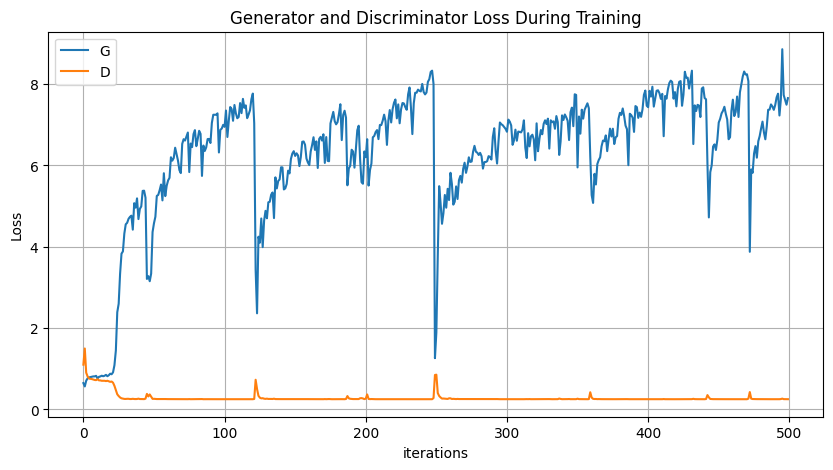

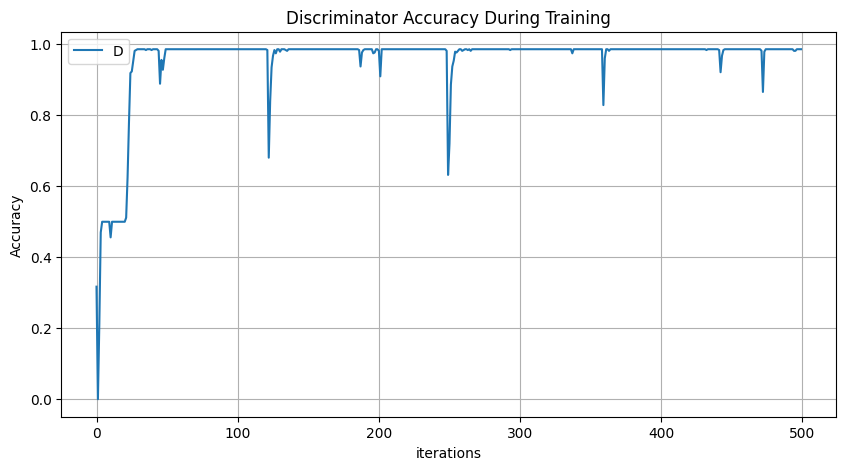

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_list, label="G")
plt.plot(d_loss_list, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Discriminator Accuracy During Training")
plt.plot(d_accuracy_list, label="D")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [9]:
print("Discriminator Accuracy = ", d_accuracy_list[-1])
print("Last G Loss = ", g_loss_list[-1])
print("Lowest G Loss = ", min(g_loss_list))

Discriminator Accuracy =  0.9861111111111112
Last G Loss =  7.656189378212999
Lowest G Loss =  0.5649159576191947


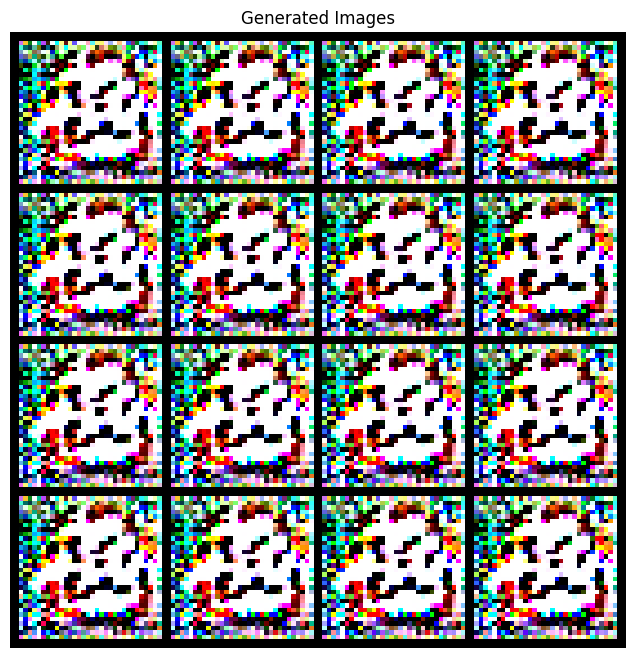

In [10]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set to evaluation mode
G.eval()

# Generate random noise (latent vectors)
num_images = 16  # Number of images to display
z = torch.randn(num_images, zdims, 1, 1, device=device)

# Generate fake images
with torch.no_grad():  # No need to track gradients
    fake_images = G(z).cpu()  # Move to CPU for visualization

# Denormalize if using normalization in training
def denormalize(img):
    img = img * 0.5 + 0.5  # Convert from [-1,1] to [0,1] if using Normalize(mean=0.5, std=0.5)
    return img.clamp(0, 1)  # Ensure values are in valid range

# Create grid of images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(
    vutils.make_grid(denormalize(fake_images), nrow=4, padding=2, normalize=False).permute(1, 2, 0)
)
plt.show()


- What most likely seems to have happenned here is that the Discriminator got a bit too good, early on in training and G collapses to a small subset of outputs with very little diversity